In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
from pandas import DataFrame
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from mpl_toolkits.mplot3d import Axes3D

from seaborn import kdeplot, distplot, set_style, despine
from matplotlib.pyplot import figure, show, title, subplots
from itertools import combinations
from seaborn import lmplot

import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\sarak\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
df = pd.read_csv("data/glass.csv")
df.shape

(214, 10)

In [4]:
X = df.drop("Type", axis = 1)
y = df["Type"]

____
## Method1

In [12]:
features = df.drop("Type", axis = 1)
target = df["Type"]

In [13]:
def find_outlier_fences_IQR(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    return [fence_low, fence_high]

fences = {}
for column in features.columns.values:
    fences[column] = find_outlier_fences_IQR(features, column)
print(fences)

#lets find rows with more than one or two outliers and drop them.
outliers_index = []
for index, row in features.iterrows():
    outliers_detected = 0
    for column in features.columns.values:
        fence_low = fences[column][0]
        fence_high = fences[column][1]
        if row[column] < fence_low or row[column] > fence_high:
            outliers_detected = outliers_detected + 1
    
    if outliers_detected > 1:
        outliers_index.append(index)

print("\nthere are %d rows found with more than 1 outlier" %(len(outliers_index)))

{'RI': [1.5125700000000006, 1.5231099999999995], 'Na': [11.53125, 15.201250000000002], 'Mg': [-0.11250000000000071, 5.827500000000001], 'Al': [0.53, 2.29], 'Si': [71.06875, 74.29875000000001], 'K': [-0.6087499999999999, 1.34125], 'Ca': [6.841250000000001, 10.57125], 'Ba': [0.0, 0.0], 'Fe': [-0.15000000000000002, 0.25]}

there are 35 rows found with more than 1 outlier


In [14]:
outliers_removed_featureset = features.drop(outliers_index)
outliers_removed_targetset = target.drop(outliers_index)

In [15]:
autoscaler = StandardScaler()
features_scaled = autoscaler.fit_transform(outliers_removed_featureset)

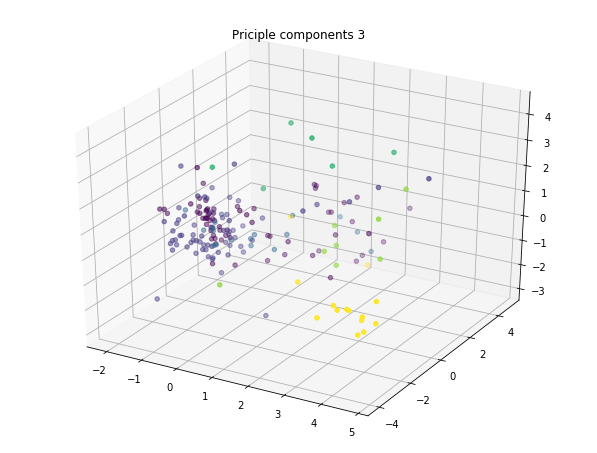

In [16]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig)
X_reduced = PCA(n_components=3).fit_transform(features_scaled.data)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=outliers_removed_targetset)
plt.title("Priciple components 3")
plt.show()

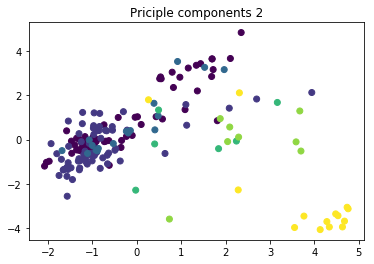

In [17]:
X_reduced = PCA(n_components=2).fit_transform(features_scaled.data)
plt.title("Priciple components 2")
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=outliers_removed_targetset)
plt.show()

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features_scaled,outliers_removed_targetset, test_size=0.20, random_state=42)

____
## Method2

Let's go ahead and perform a PCA on the features to decorrelate the ones that are linearly dependent and then let's plot the cumulative explained variance.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

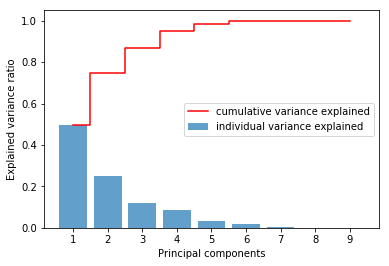

PC1 Cumulative variance: 49.554%
PC2 Cumulative variance: 74.650%
PC3 Cumulative variance: 86.732%
PC4 Cumulative variance: 95.099%
PC5 Cumulative variance: 98.219%
PC6 Cumulative variance: 99.819%
PC7 Cumulative variance: 99.975%
PC8 Cumulative variance: 100.000%
PC9 Cumulative variance: 100.000%


In [9]:
seed = 42
pca = PCA(random_state = seed)
pca.fit(X_train)
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)
plt.bar(range(1,len(cum_var_exp)+1), var_exp, align= 'center', label= 'individual variance explained', \
       alpha = 0.7)
plt.step(range(1,len(cum_var_exp)+1), cum_var_exp, where = 'mid' , label= 'cumulative variance explained', \
        color= 'red')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.xticks(np.arange(1,len(var_exp)+1,1))
plt.legend(loc='best')
plt.show()

# Cumulative variance explained
for i, sum in enumerate(cum_var_exp):
    print("PC" + str(i+1), "Cumulative variance: %.3f% %" %(cum_var_exp[i]*100))

____
## Method3

In [4]:
# Detect observations with more than one outlier
from collections import Counter
def outlier_hunt(df):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than 2 outliers. 
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in df.columns.tolist():
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        
        # Interquartile rrange (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > 2 )
    
    return multiple_outliers   

In [5]:
features = df.columns[:-1].tolist()
print('The dataset contains %d observations with more than 2 outliers' %(len(outlier_hunt(df[features]))))

The dataset contains 14 observations with more than 2 outliers


In [6]:
outlier_indices = outlier_hunt(df[features])
df = df.drop(outlier_indices).reset_index(drop=True)
print(df.shape)

(200, 10)


In [7]:
X = df.drop("Type", axis = 1)
y = df["Type"]

In [8]:
X.shape

(200, 9)

In [9]:
y.shape

(200,)

In [10]:
pca = PCA()
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [11]:
pca.n_components_

9

In [14]:
# Explained Variance

DataFrame(pca.explained_variance_.round(2), 
          index=["P" + str(i) for i in range(0,len(X.columns))], columns=["Explained Variance"]).T

,P0,P1,P2,P3,P4,P5,P6,P7,P8
Explained Variance,2.47,0.96,0.56,0.14,0.06,0.04,0.01,0.0,0.0


In [15]:
# Explained Variance Ratio
DataFrame(pca.explained_variance_ratio_.round(2), 
          index = ["P" + str(i) for i in range(0,len(X.columns))], columns=["Explained Variance Ratio"]).T

,P0,P1,P2,P3,P4,P5,P6,P7,P8
Explained Variance Ratio,0.58,0.23,0.13,0.03,0.01,0.01,0.0,0.0,0.0


<b> Note: </b> First 3 components explained variance score in total would be 94%

In [16]:
components_applied = DataFrame(pca.transform(X))
components_applied.columns = ["P" + str(i) for i in range(0,len(X.columns))]
components_applied.round(2).head()

,P1,P2,P3,P4,P5,P6,P7,P8,P9
0,-1.57,0.70,-1.01,0.02,-0.22,-0.23,-0.07,0.01,-0.0
1,-1.07,-0.73,-0.51,0.20,0.24,0.00,-0.04,-0.02,-0.0
2,-1.06,-0.85,-0.10,0.11,0.12,-0.20,-0.04,0.02,-0.0
3,-1.14,-0.19,-0.03,-0.04,0.02,0.08,-0.05,0.09,-0.0
4,-1.10,-0.50,0.20,0.26,0.08,0.00,-0.05,-0.00,-0.0


In [17]:
for p in components_applied.columns:
    
    new_df = X.copy()
    new_df[p] = components_applied[p]
    display(DataFrame(new_df.corr().round(2)[p]).drop(p,0).T)

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
P1,0.18,0.45,-0.98,0.47,0.21,-0.45,0.64,0.56,-0.13


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
P2,0.82,-0.3,0.17,-0.61,-0.56,-0.07,0.77,-0.54,0.1


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
P3,-0.27,-0.81,-0.06,0.03,0.72,0.56,0.06,-0.22,0.09


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
P4,0.04,0.18,0.02,-0.59,0.33,-0.34,0.02,0.01,-0.09


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
P5,-0.15,0.12,-0.01,0.03,0.04,0.34,-0.0,-0.56,-0.09


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
P6,0.12,-0.0,-0.03,-0.24,-0.08,0.5,-0.03,0.19,0.05


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
P7,-0.02,-0.0,-0.0,-0.01,-0.01,-0.02,-0.01,-0.02,0.97


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
P8,-0.08,-0.02,-0.01,-0.03,-0.02,-0.05,-0.01,-0.04,-0.06


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
P9,-0.41,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Distribution Plots of Each Component by Glass Type

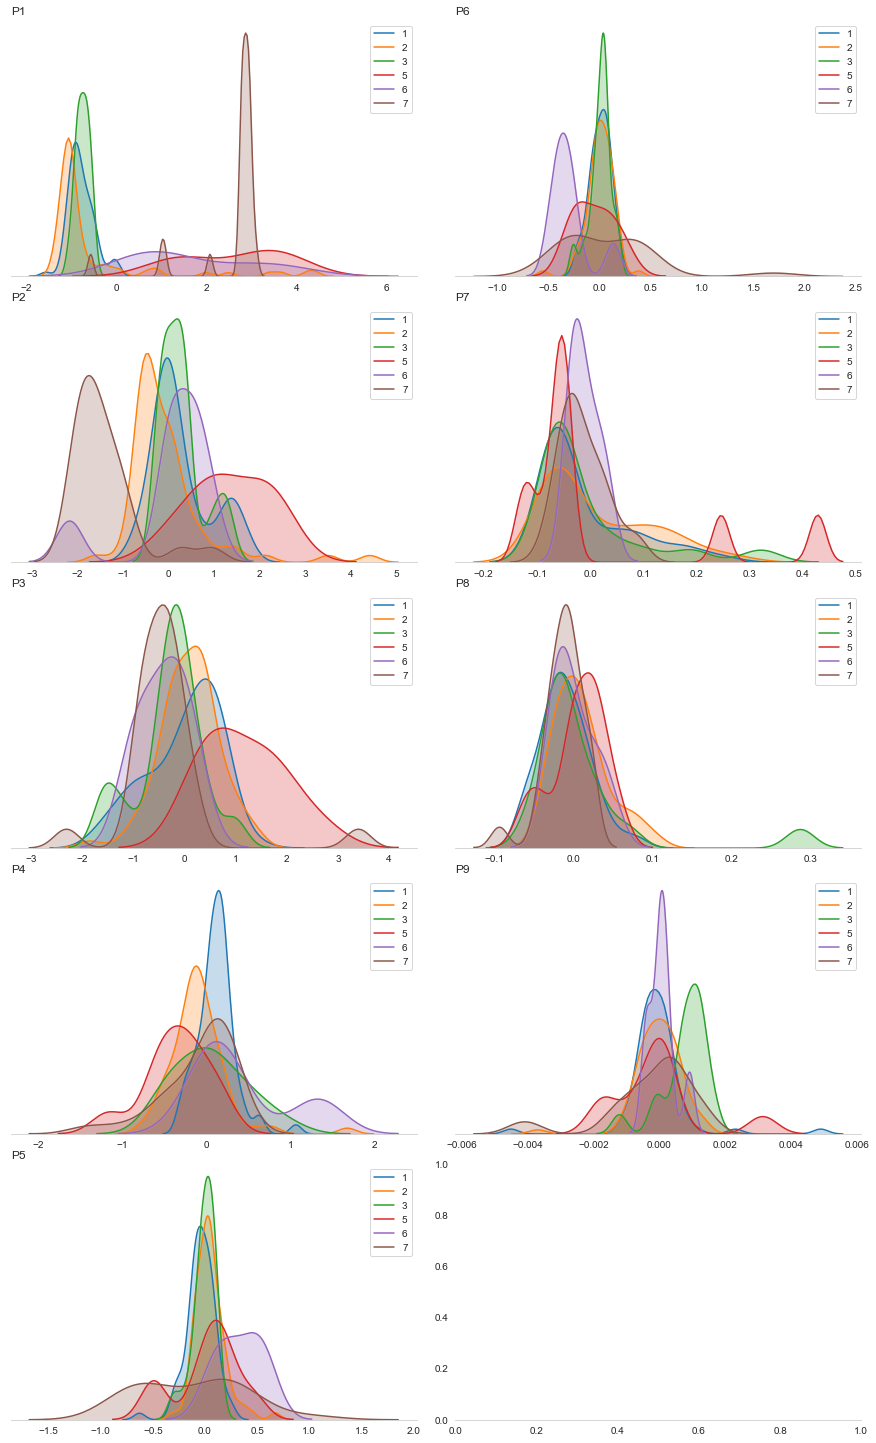

In [24]:
set_style("whitegrid")
set_style({"axes.grid":False})

for_plotting = components_applied.copy()
for_plotting["Type"] = y

n = 10
fig, axes = subplots(int(10/2),2, figsize=(12.5,20))
fig.tight_layout()
i = 0
j = 0


for p in components_applied.columns:
    
    for t in for_plotting["Type"].unique():
        data_by_type = for_plotting[for_plotting["Type"] == t]
        kdeplot(pd.Series(data_by_type[p], name = t), shade=True, ax=axes[i][j])
#         distplot(pd.Series(data_by_type[p], name = t), kde=False, ax=axes[i][j])
        axes[i][j].set_title(p, loc="left")
        axes[i][j].set_xlabel("",visible=False)
        axes[i][j].set_yticklabels([],visible=False)
        despine(left=True)
    i += 1
    
    if(i == n/2):
        i = 0
        j += 1
    
plt.show()

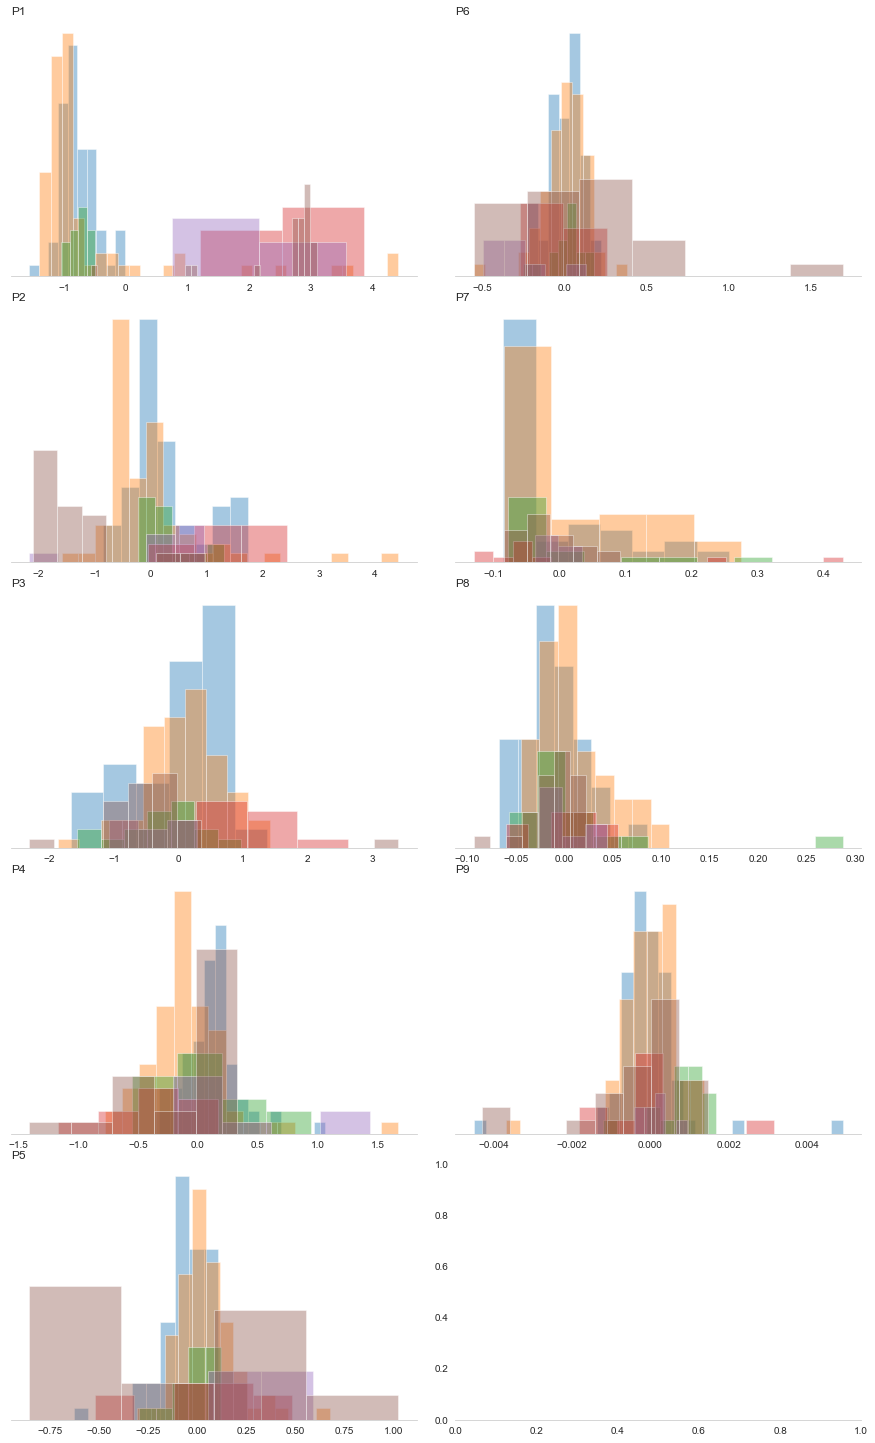

In [23]:
set_style("whitegrid")
set_style({"axes.grid":False})

for_plotting = components_applied.copy()
for_plotting["Type"] = y

n = 10
fig, axes = subplots(int(10/2),2, figsize=(12.5,20))
fig.tight_layout()
i = 0
j = 0


for p in components_applied.columns:
    
    for t in for_plotting["Type"].unique():
        data_by_type = for_plotting[for_plotting["Type"] == t]
#         kdeplot(pd.Series(data_by_type[p], name = t), shade=True, ax=axes[i][j])
        distplot(pd.Series(data_by_type[p], name = t), kde=False, ax=axes[i][j])
        axes[i][j].set_title(p, loc="left")
        axes[i][j].set_xlabel("",visible=False)
        axes[i][j].set_yticklabels([],visible=False)
        despine(left=True)
    i += 1
    
    if(i == n/2):
        i = 0
        j += 1
    
plt.show()

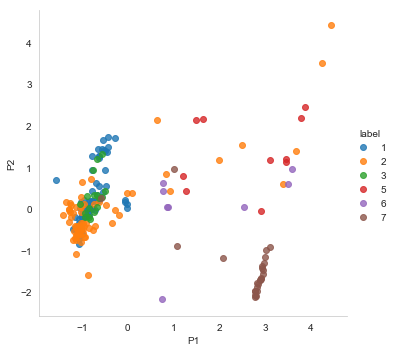

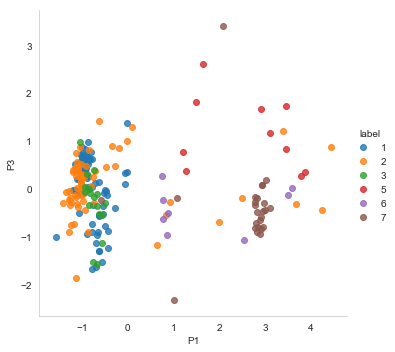

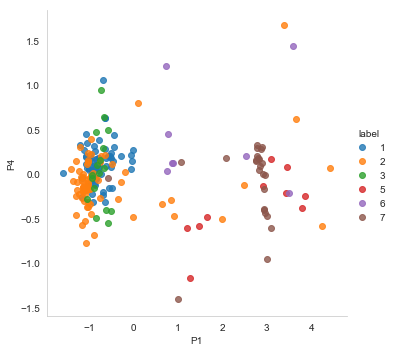

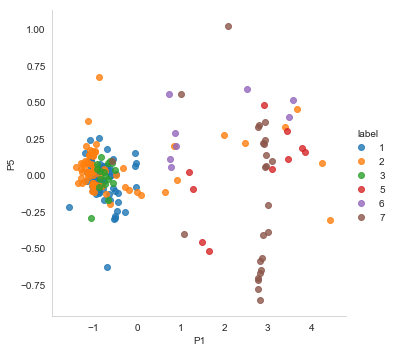

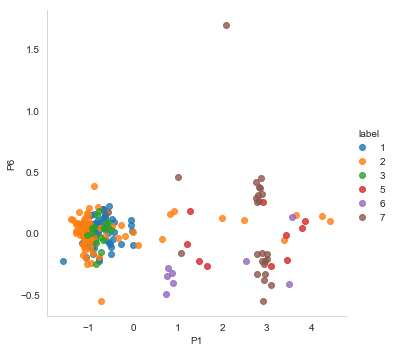

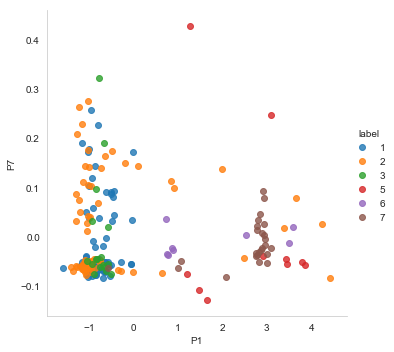

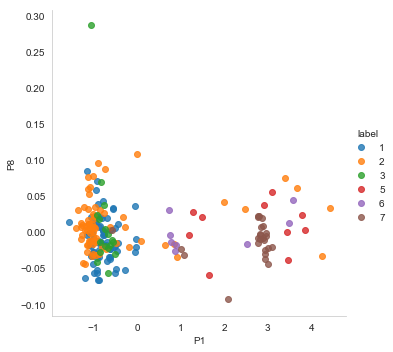

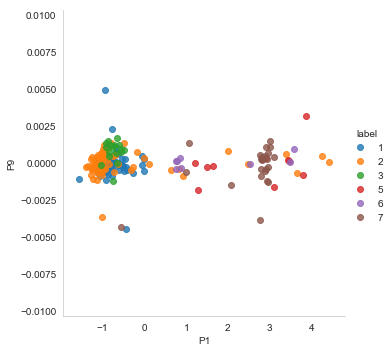

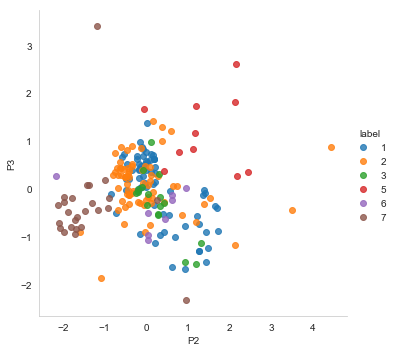

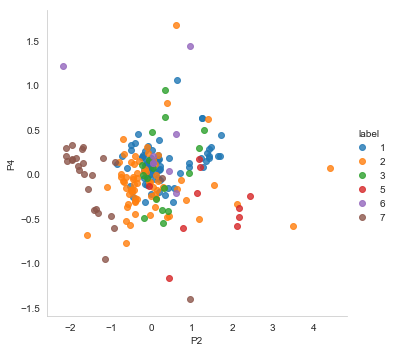

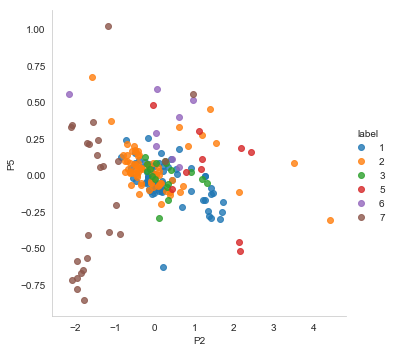

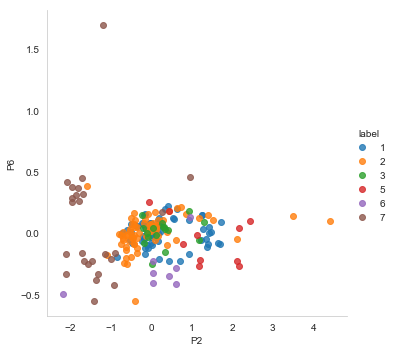

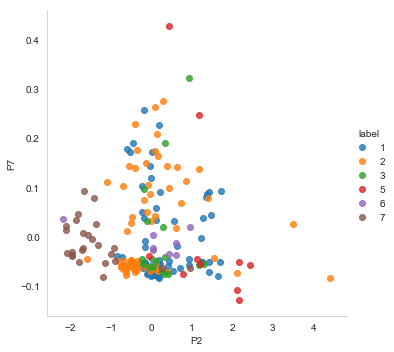

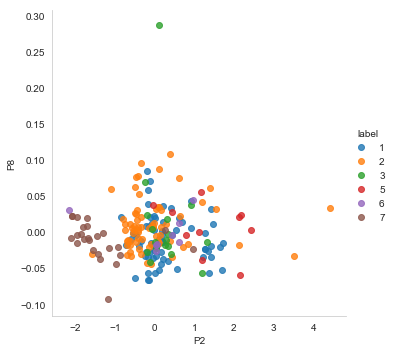

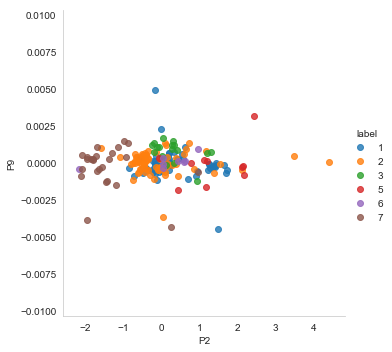

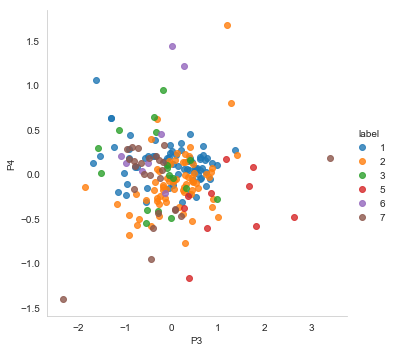

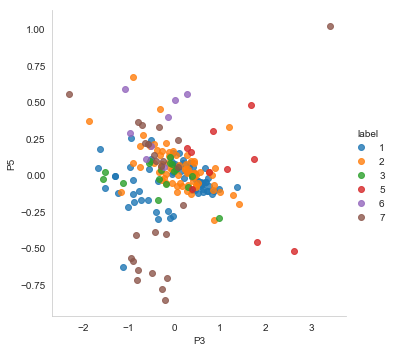

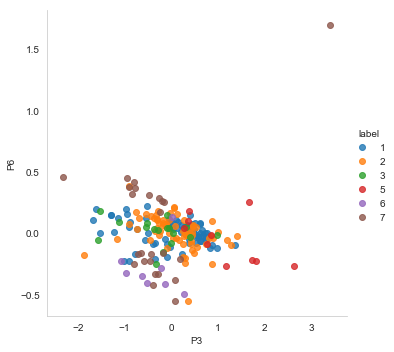

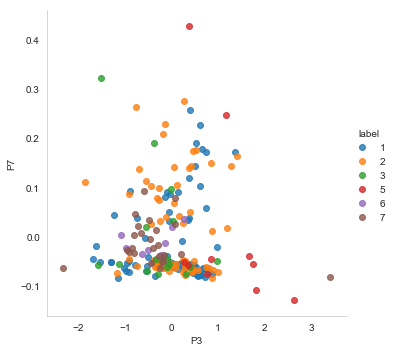

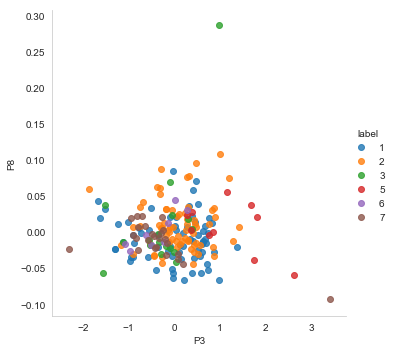

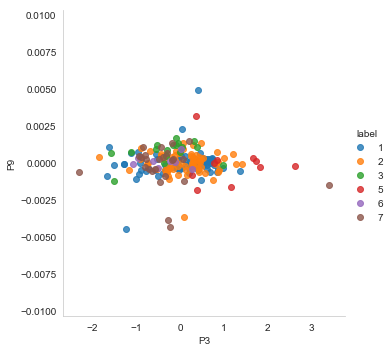

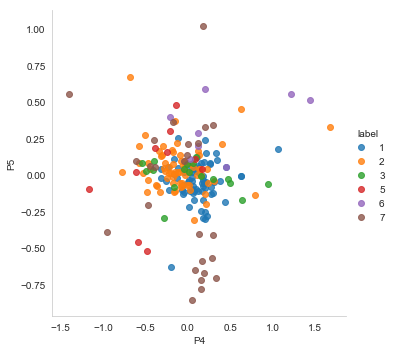

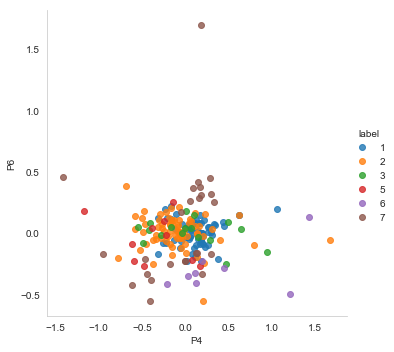

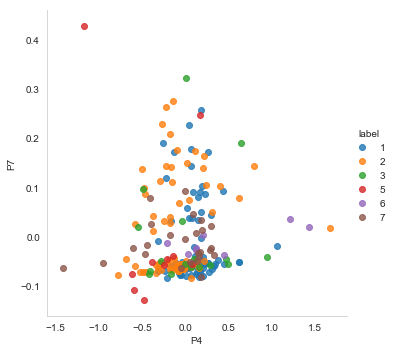

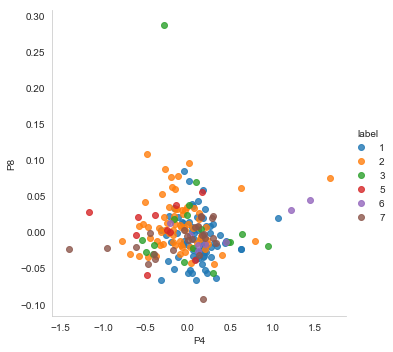

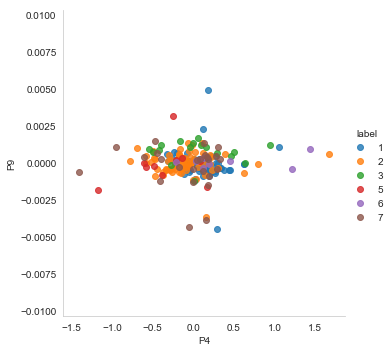

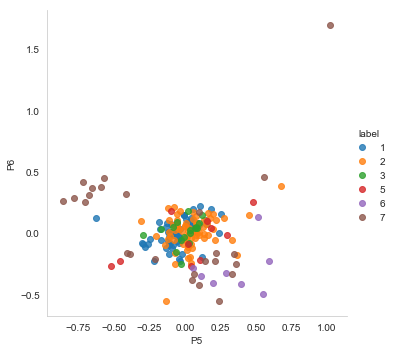

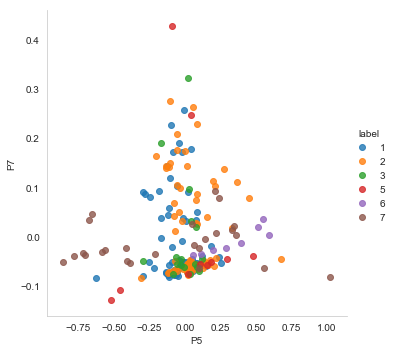

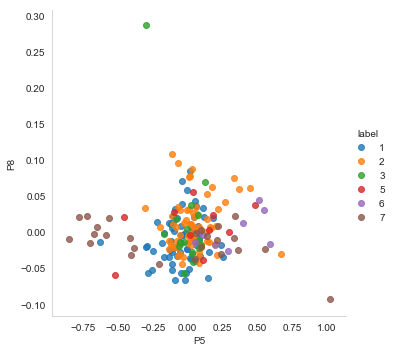

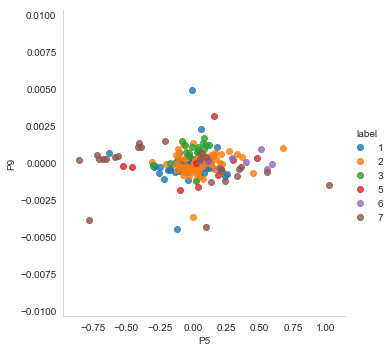

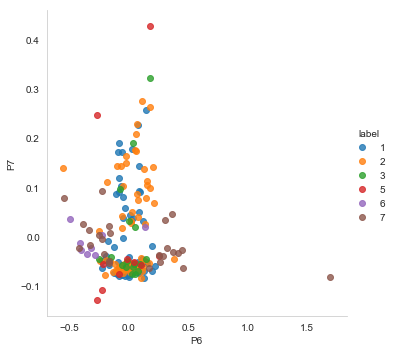

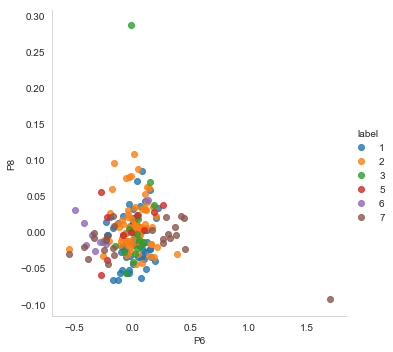

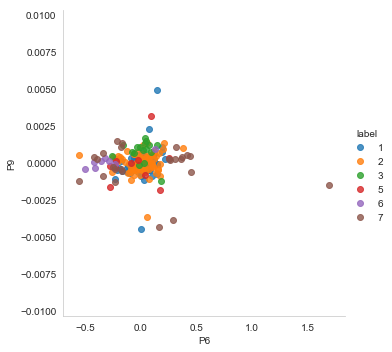

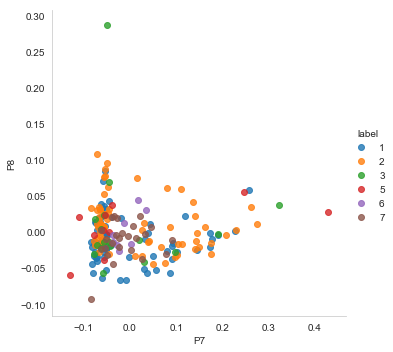

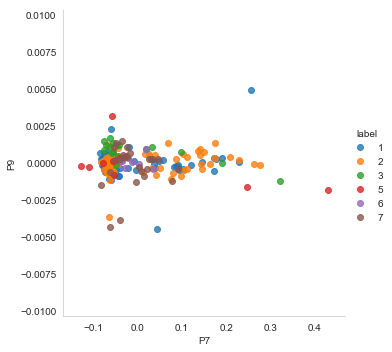

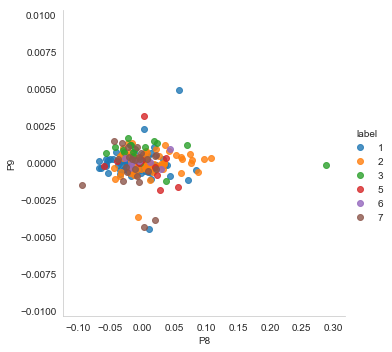

In [27]:
scatter_data = components_applied.copy()
scatter_data["label"] = y

for a,b in combinations(components_applied.columns,2):
    lmplot(data=scatter_data,x=a,y=b, hue="label", fit_reg=False)
    plt.show()